In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torch.utils.data import random_split

import matplotlib.pyplot as plt

In [2]:
class LinearRegression(torch.nn.Module):
    def __init__(self, width, depth):
        super().__init__()

        self.input_l = torch.nn.Linear(2, width)
        self.hidden_l = torch.nn.ModuleList([torch.nn.Linear(width, width) for i in range(depth)])
        self.output_l = torch.nn.Linear(width, 1) # two hidden layer, Depth = 2
    
    def forward(self, x):
        a = self.input_l(x)
        for linear in self.hidden_l:
            a = linear(a)
        return self.output_l(a)

linear_regression_model = LinearRegression(width = 10, depth = 10)
linear_regression_model

LinearRegression(
  (input_l): Linear(in_features=2, out_features=10, bias=True)
  (hidden_l): ModuleList(
    (0-9): 10 x Linear(in_features=10, out_features=10, bias=True)
  )
  (output_l): Linear(in_features=10, out_features=1, bias=True)
)

In [3]:
def noise(shape, low=-1.0, high=1.0):
    return (high - low) * torch.rand(shape) + low

def fn(x):
    # return np.sin(x) + noise(x.shape, low=0, high=1)
    # return np.sin(x) #+ noise(x.shape, low=0, high=1)
    # return x*10 #+ noise(x.shape, low=0, high=1)

    return torch.sin(x[:, 0].unsqueeze(1)) + torch.cos(x[:, 1].unsqueeze(1)) + noise(x.shape, low=0, high=1) # x[:, 0] are xs; x[:, 0] are the ys

class x_y_ds(Dataset):
    def __init__(self, fn, N):
        # self.xs = torch.linspace(min, max, N).unsqueeze(1)
        # self.ys = fn(self.xs)

        self.xs = torch.rand(N, 2)
        self.ys = fn(self.xs)

    def __len__(self):
        return len(self.ys)

    def __getitem__(self, idx):
        return self.xs[idx], self.ys[idx]
    
data = x_y_ds(fn, N = 100)
training_dataset, test_dataset = random_split(
    data, [80, 20]
)
    
train_dataloader = DataLoader(dataset = training_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(dataset = test_dataset, batch_size=10, shuffle=False)

In [19]:
widths = [1, 10, 20, 30]
depths = [1, 10, 20, 30]

logs = {}
nn_enum = 0
for w in widths:
    for d in depths:
        logs[f"NN{nn_enum}"] = {
                    "width": w,
                    "Depth": d,
                    "train_loss": [],
                    "test_loss": []
                    }
        nn_enum += 1

In [20]:
loss_fn = torch.nn.MSELoss()

epsilon = 0.1
epochs = 1000



for NN, log in logs.items():
    model = LinearRegression(width=log["width"], depth=log["Depth"])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(epochs):
        epoch_loss_train= 0
        for x_batch, y_batch in train_dataloader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            epoch_loss_train+= loss.item()
            loss.backward()
            optimizer.step()
        
        epoch_loss_train /= len(train_dataloader)
        
        epoch_loss_test = 0
        with torch.no_grad():
            for x_batch_test, y_batch_test in test_dataloader:
                y_pred_test = model(x_batch_test)
                loss_test = loss_fn(y_pred_test, y_batch_test)
                epoch_loss_test += loss_test.item()
            epoch_loss_test /= len(test_dataloader)

        log["train_loss"].append(epoch_loss_train)
        log["test_loss"].append(epoch_loss_test)

        if epoch % 100 == 0:
            print(f"Epoch {epoch} | train loss = {epoch_loss_train:.4f} | test loss = {epoch_loss_test:.4f}")

        if (epoch_loss_train < epsilon) and (epoch_loss_test < epsilon): 
            print("converged")
            break


Epoch 0 | train loss = 6.9045 | test loss = 5.4633
Epoch 100 | train loss = 0.0784 | test loss = 0.1107
Epoch 200 | train loss = 0.0757 | test loss = 0.1038
Epoch 300 | train loss = 0.0753 | test loss = 0.1052
Epoch 400 | train loss = 0.0753 | test loss = 0.1044
Epoch 500 | train loss = 0.0758 | test loss = 0.1062
Epoch 600 | train loss = 0.0761 | test loss = 0.1052
Epoch 700 | train loss = 0.0750 | test loss = 0.1039
Epoch 800 | train loss = 0.0753 | test loss = 0.1032
Epoch 900 | train loss = 0.0749 | test loss = 0.1039
Epoch 0 | train loss = 2.0645 | test loss = 1.4892
converged
Epoch 0 | train loss = 3.3140 | test loss = 2.6687
converged
Epoch 0 | train loss = 7.0864 | test loss = 5.7205
Epoch 100 | train loss = 0.1618 | test loss = 0.2849
Epoch 200 | train loss = 0.1493 | test loss = 0.2398
Epoch 300 | train loss = 0.1506 | test loss = 0.2375
Epoch 400 | train loss = 0.1516 | test loss = 0.2541
Epoch 500 | train loss = 0.1477 | test loss = 0.2716
Epoch 600 | train loss = 0.1468 | 

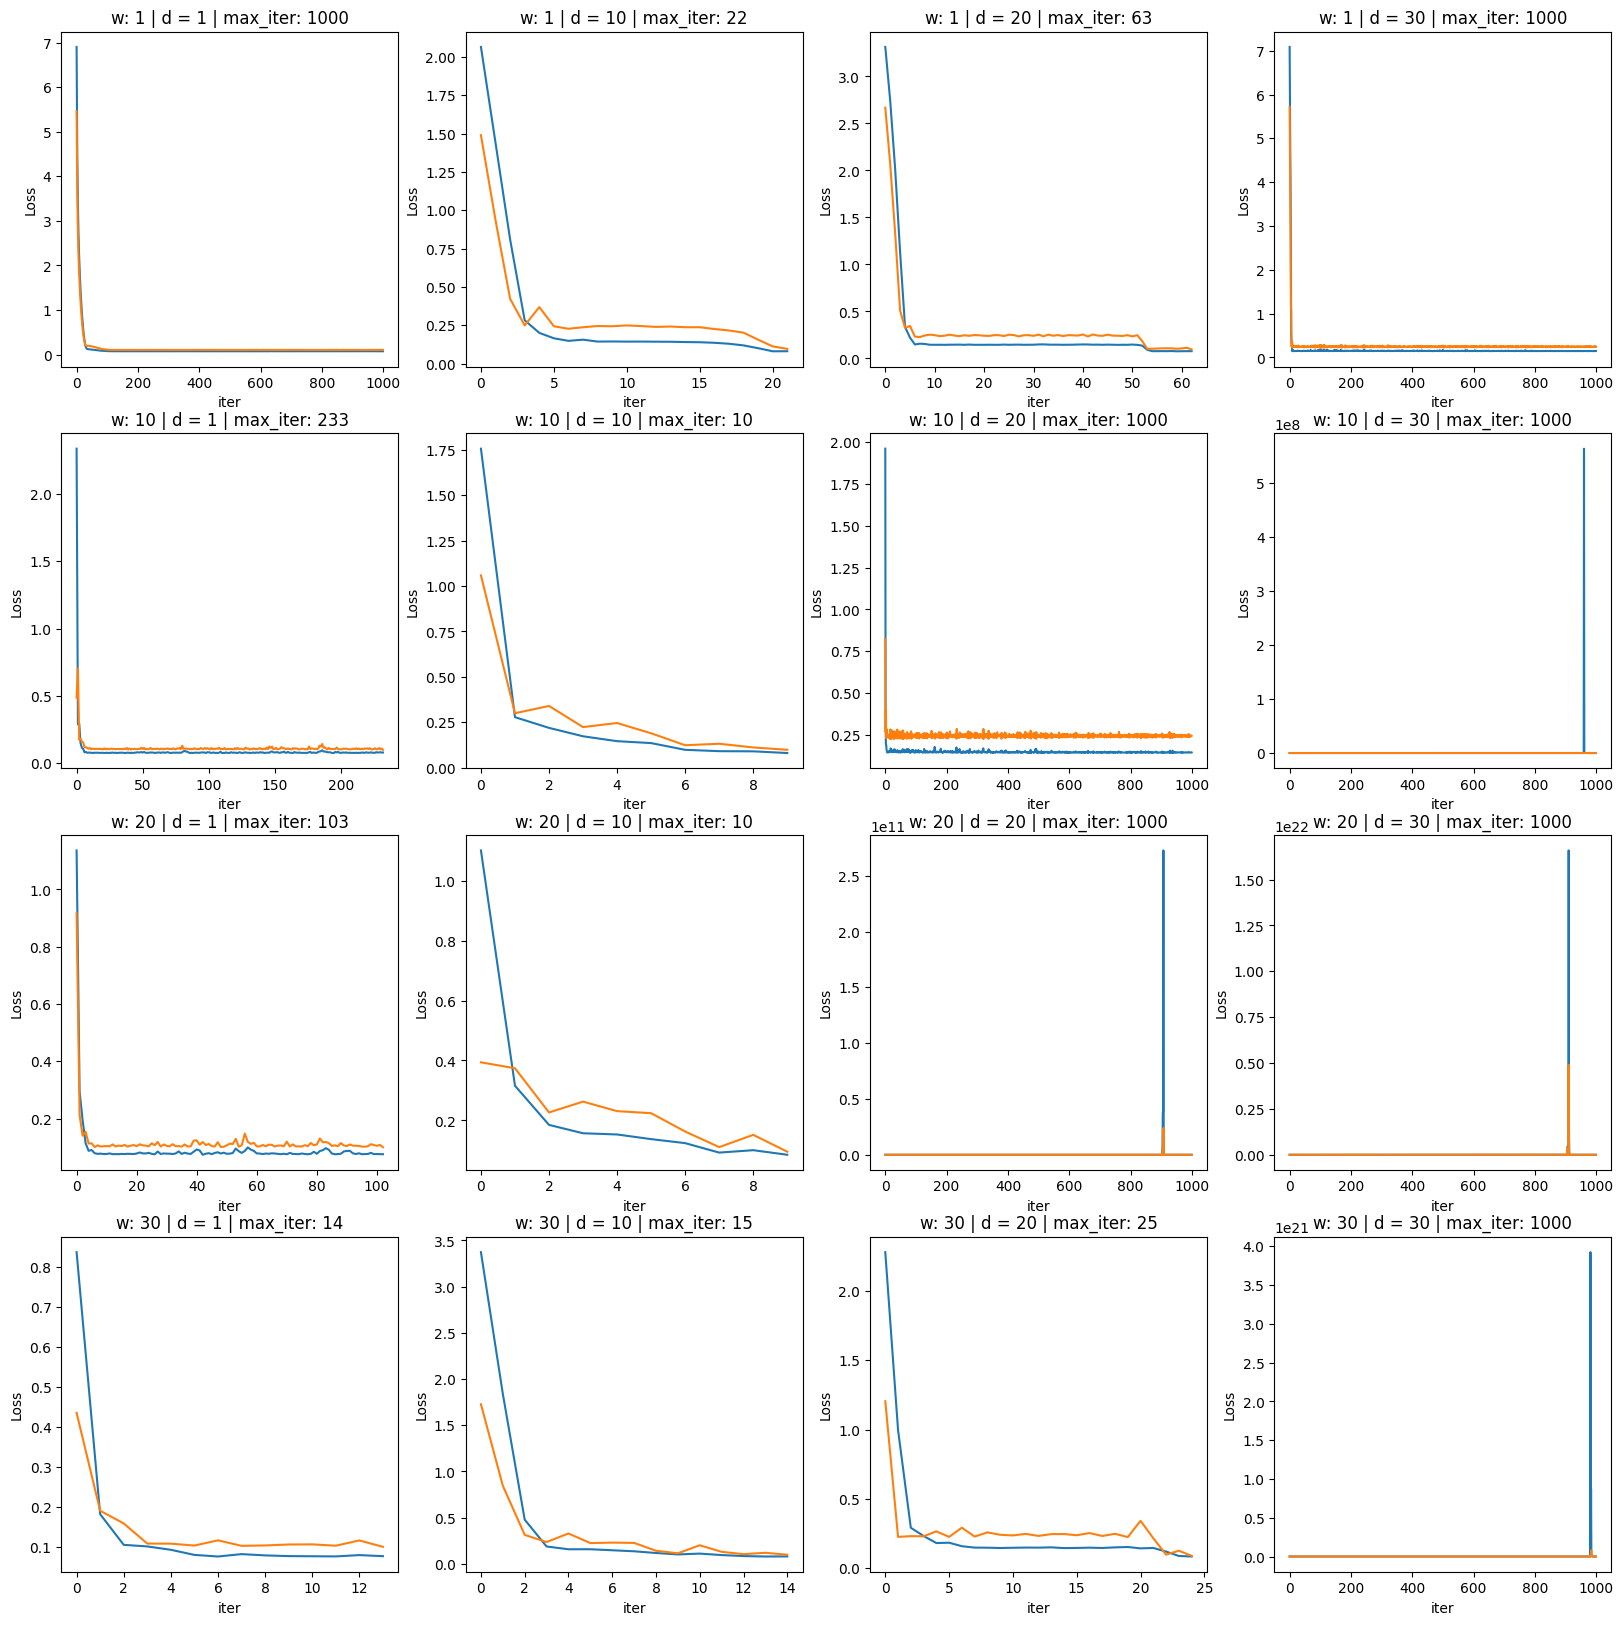

In [66]:
fig, axes = plt.subplots(len(widths), len(depths), figsize=(20, 20))

nn_enum = 0
for i, w in enumerate(widths):
    for j, d in enumerate(depths):
        log = logs[f"NN{nn_enum}"]
        axes[i][j].plot(log["train_loss"])
        axes[i][j].plot(log["test_loss"])
        nn_enum += 1

        axes[i][j].set(xlabel='iter', ylabel='Loss')
        axes[i][j].set_title(f"w: {log['width']} | d = {log['Depth']} | max_iter: {len(log['train_loss'])}")



In [63]:
len(log["train_loss"])

1000

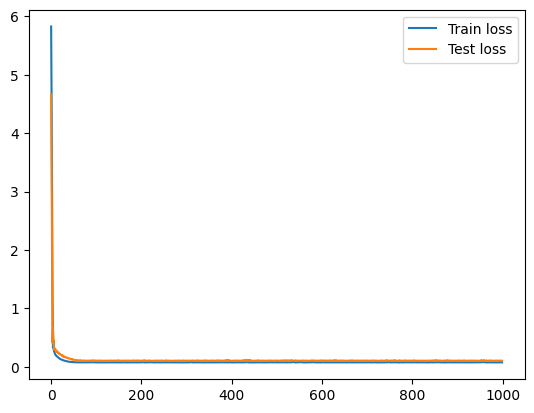

In [7]:
plt.plot(logs['NN2']['train_loss'], label='Train loss')
plt.plot(logs['NN2']['test_loss'], label='Test loss')
plt.legend()